Pipeline do trabalho:
- Capa e contracapa, sumário e resumo:
- Introdução:
    + Apresentação do trabalho;
    + Detalhamento dos dados, motivação e afins.
- Dados e metodologia:
    + Exploração inicial dos dados (primeiras visualizações gráficas e estatísticas descritivas básicas) e realização dos testes de raiz (adf,pp,kpss)
    + Decomposição e filtros nos dados (tirar tendência e tirar sazonalidade), e após isso refazer testes de raiz para confirmar sua não existência.
- OBS: Aqui já sabemos que a série possui sim uma raiz unitária e sazonalidade significativa, a ideia é seguir retirando esses dois componentes. A raiz deve ser retirada devido ao fato de estarmos trabalhando com modelos estacionários, com a diferenciação a série passa a ser estacionaria e não perde quantidade significativa de informação então ainda podemos tirar informações dela (mais especificamente perde apenas um grau de liberdade dos 150 aproximadamente que temos). Quanto a sazonalidade na base acho que a melhor abordagem e sua retirada, uma vez que ela torna o processo de previsão muito mais complexo e pode levar a interpretações erradas quando tivermos os resultados dos modelos se não a incorporarmos direito, portanto deve ser filtrada também, podemos fazer isso bem de boa com o pacote statsmodels.
O Milton falou que devemos “colocar a série temporal em perspectiva ao problema a que se referem, principalmente em sintonia com a política econômica brasileira”, então aqui acho válido relacionar o trabalho com políticas públicas de alguma forma.
- Ajuste de qual modelo selecionado para representação dos dados (Começamos com modelos maiores e redução até melhor modelo enxuto)
    + Avaliação do modelo com análise de resíduos (normalidade do erro, autocorrelação, heterocedasticidade)
    + Métricas de performance do modelo (MSE,RMSE...)
- OBS: Aqui é uma parte mais chatinha no sentido de que temos de interpretar o gráfico e entender que modelo melhor representa nossa série. Acontece que fica algo fraco se so falarmos “ah é tal modelo”, então o que a Roseli por exemplo pedia para fazer é analisar o maior modelo que se encaixaria no que vemos nas funções FAC e FACP. Na minha interpretação o maior modelo que poderíamos tentar é um ARMA(4,4), e irmos fazendo outros menores até encontrar o que tenha a melhor relação dos itens avaliadores de modelo ( estatísticas de erro acima citadas)(Vamos começar com ARMA(4,4) e ir reduzindo até ARMA(1,1) depois AR e MA de 4 até 1, isso nos dará mais robustez para colocarmos qual foi o melhor modelo dentre vários que tem uma boa explicação da realidade sem ter tanto overfitting por ser demasiadamente grande) Outra coisa é achar uma função que acha os lags ótimos para os modelos, não sei como fazer isso no python na prática, porém essa é uma ferramenta que existe no Eviews e portanto deve existir no python tbm. Com ela o algoritmo já encontra qual é o lag ótimo para começar a modelagem, ao invés de começar do 4 e ir descendo vai descendo a partir desse lag ótimo.. Daí teremos no final o melhor dos modelos para que possamos seguir com a previsão. Podemos sumarizar todas essas estatísticas em uma tabela e colocar para provar a robustez da decisão
- Resultados:
    + Previsão de período a frente e comparação com o que de fato foi
- Conclusão
- Apêndice com informações a mais como ARCH, GARCH (OPICIONAL])
=> OBS: Não acho que seja necessário modelar a variância para que o trabalho tenha boa performance quanto a nota, porém podemos fazer caso seja de consentimento geral. Nesse caso imagino incluir essa parte em um apêndice uma vez que foge de certa forma da descrição que o Milton deu do que deve ser feito no corpo principal do trabalho.



In [802]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from statsmodels.tsa.seasonal import seasonal_decompose, STL #Dessazonalização da série forma multiplicatica e aditiva(Media móvel) e por STL
from sklearn.metrics import mean_absolute_error, mean_squared_error # Medidas de desempenho por erro
from arch.unitroot import PhillipsPerron,ADF,KPSS,DFGLS #testes de raiz unitária
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


diretorio = "C:/Users/DESKTOP 15/Desktop/trab_eco_3/"
dados = []

for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.csv'):
        caminho = os.path.join(diretorio, arquivo)
        basesprf = pd.read_csv(caminho, sep = ';', encoding = 'ISO-8859-1')
        dados.append(basesprf)

acidentes = pd.concat(dados, ignore_index = True)

acidentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540537 entries, 0 to 540536
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      540537 non-null  float64
 1   pesid                   164889 non-null  float64
 2   data_inversa            540537 non-null  object 
 3   dia_semana              540537 non-null  object 
 4   horario                 540537 non-null  object 
 5   uf                      540537 non-null  object 
 6   br                      540053 non-null  float64
 7   km                      540053 non-null  object 
 8   municipio               540537 non-null  object 
 9   causa_acidente          540537 non-null  object 
 10  tipo_acidente           540468 non-null  object 
 11  classificacao_acidente  540536 non-null  object 
 12  fase_dia                540536 non-null  object 
 13  sentido_via             540537 non-null  object 
 14  condicao_metereologi

In [803]:
#Tirando duplicados
acidentes_semdup = acidentes[['id', 'data_inversa']].drop_duplicates()
acd_sdcopia = acidentes_semdup.copy()

#Conversão em datetime
acd_sdcopia['data_inversa'] = pd.to_datetime(acd_sdcopia['data_inversa'], format = 'mixed')
acd_sdcopia.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 444977 entries, 0 to 540536
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            444977 non-null  float64       
 1   data_inversa  444977 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.2 MB


Dias:  1826


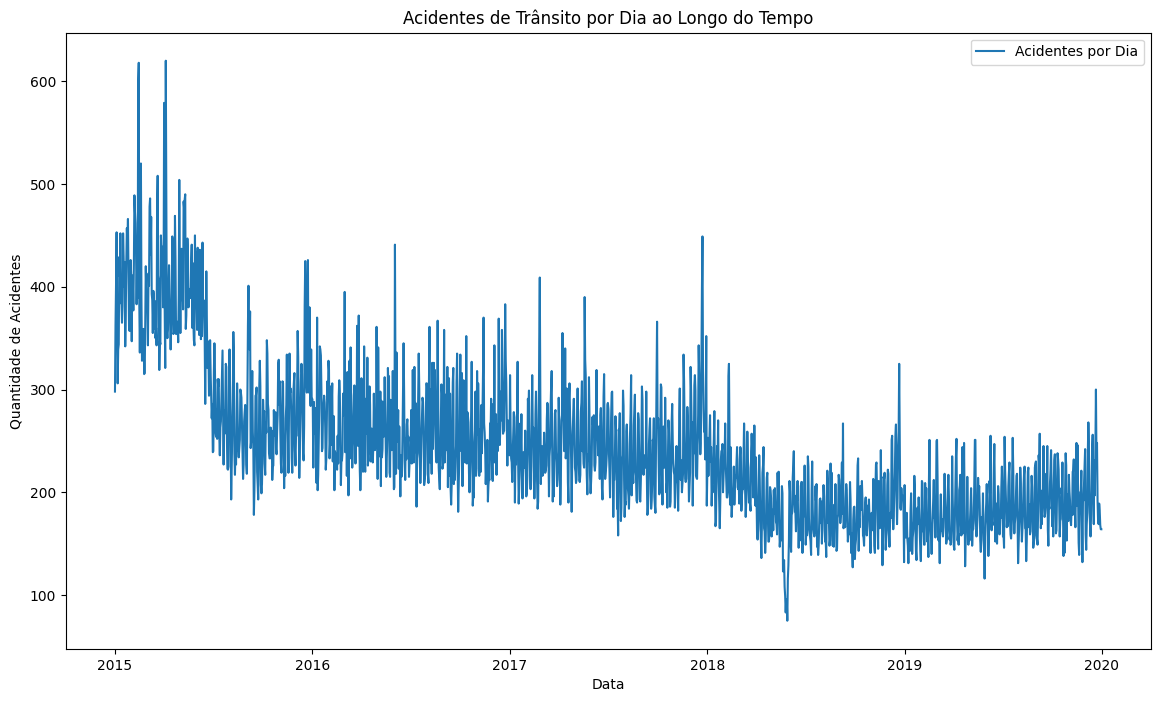

In [804]:
#Abordagem diária

#Contagem de acidentes por dia
acd_dia = acd_sdcopia.groupby('data_inversa').size().reset_index(name='Qtd_Acidentes_Dia')

#Contagem de dias
dias = len(acd_dia)
print("Dias: " , dias)

#Gráfico de acidentes por dia
plt.figure(figsize=(14, 8))
sns.lineplot(x='data_inversa', y='Qtd_Acidentes_Dia', data = acd_dia, label='Acidentes por Dia')
plt.title('Acidentes de Trânsito por Dia ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes')

plt.show()


A abordagem diária nao é interessante, muita variação brusca. Temos de justificar a escolha de um período maior. No caso será uma abordagem por semana que trouxe uma boa visualização do gráfico. A mensal ficou mais ou menos a mesma coisa e sacrificou muita informação da base, portanto a abordagem escolhida foi a semanal

Semanas:  262


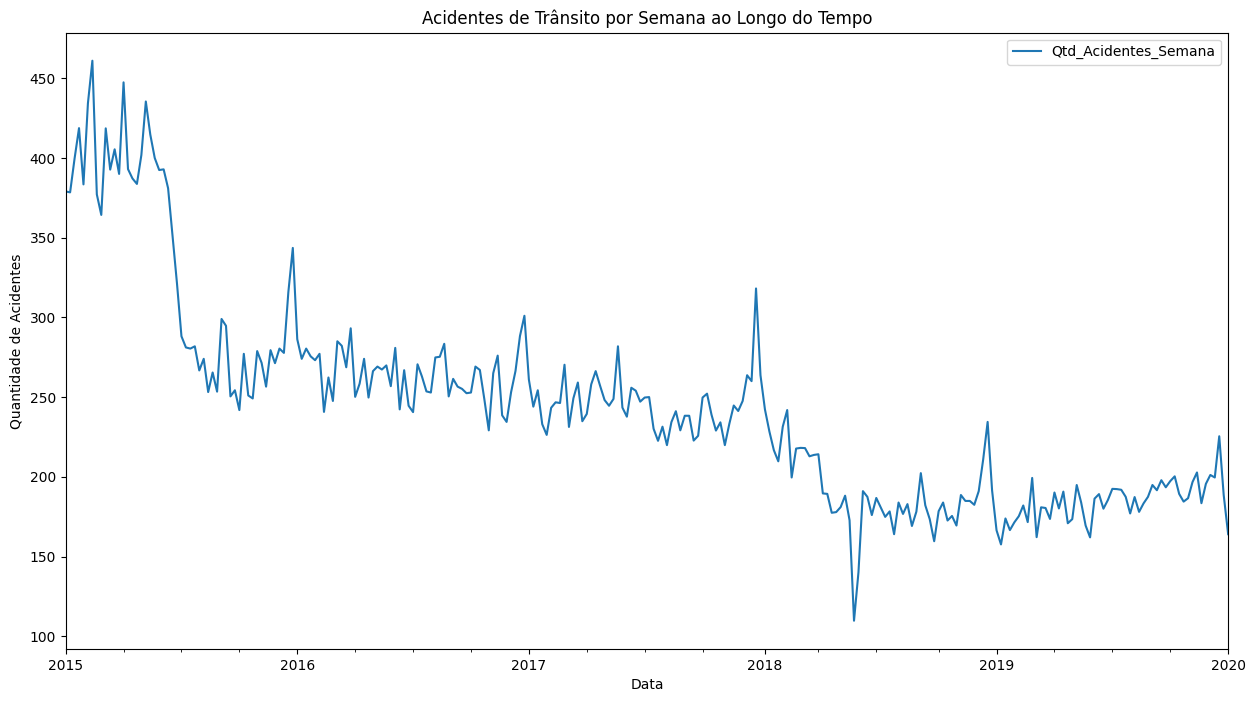

In [805]:
#Abordagem Semanal

#Variável de Acidentes em Cada Semana
acd_sdcopia['Qtd_Acidentes_Semana'] = acd_sdcopia['data_inversa'].dt.to_period('W').astype(str)

#Contagem de Acidentes por Semana
acd_sem = acd_sdcopia.groupby('data_inversa').count()
acd_sem = acd_sem.resample('W').mean()
acd_sem['id'] = acd_sem['Qtd_Acidentes_Semana']
acd_sem = acd_sem.drop('id', axis=1)

#Contagem de Semanas
semanas = len(acd_sem)
print("Semanas: ", semanas)

#Gráfico de Acidentes por Semana
acd_sem.plot(figsize = (15,8))
plt.title('Acidentes de Trânsito por Semana ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes')

plt.show()

In [806]:
acd_sem.head()

,Qtd_Acidentes_Semana
data_inversa,
2015-01-04,379.000000
2015-01-11,378.428571
2015-01-18,399.571429
2015-01-25,418.714286
2015-02-01,383.428571


60


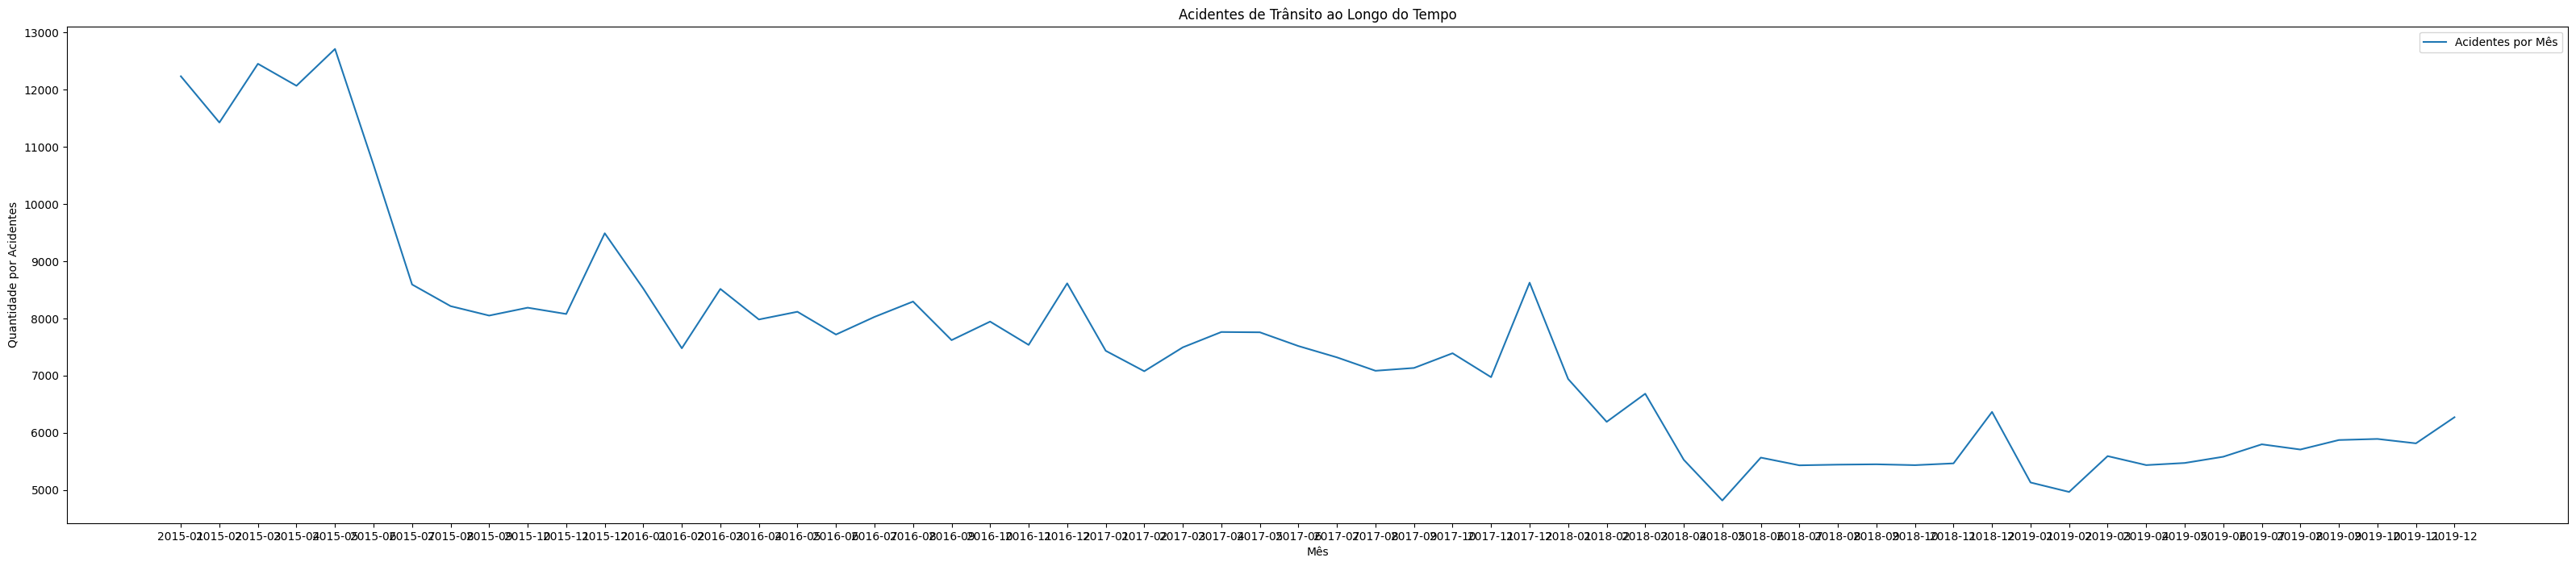

In [807]:
#Abordagem Mensal
#Variável ano_mes
acd_sdcopia['ano_mes'] = acd_sdcopia['data_inversa'].dt.to_period('M').astype(str)

#Contagem de acidentes por ano e mês
acd_anomes = acd_sdcopia.groupby('ano_mes').size().reset_index(name='Qtd_Acidentes_Mes')

#Contagem de Meses
meses = len(acd_anomes)
print(meses)

#Gráfico de acidentes por mês/ano
plt.figure(figsize=(40,8))
sns.lineplot(x = 'ano_mes', y = 'Qtd_Acidentes_Mes', data = acd_anomes, label = 'Acidentes por Mês')
plt.title('Acidentes de Trânsito ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Quantidade por Acidentes')

plt.show()

Comparação dos Modelos
- Modelo Aditivo: Útil quando a amplitude da sazonalidade é constante ao longo do tempo.
- Modelo Multiplicativo: Melhor quando a amplitude da sazonalidade varia com o nível da série temporal.
- STL: É um modelo mais robusto que peca em simplicidade, porém tenta utilizar de métodos mais complexos para fazer a decomposição

Decomposição Aditiva e Multiplicativa

- Modelo Aditivo:
    - Assumimos que a série é a soma da tendência, sazonalidade e ruído.
    - Fórmula: $Y(t)=T(t)+S(t)+R(t)$

- Modelo Multiplicativo:
    - Assumimos que a série é o produto da tendência, sazonalidade e ruído.
    - Fórmula: $Y(t)=T(t)×S(t)×R(t)$

Portanto para a dessazonalização da série devemos retirar a parte de sazonalidade de cada um

Para o Modelo Aditivo:
Subtraímos o componente sazonal da série original.
Fórmula: $Y_{\text{dessazonalizado}}(t) = Y(t)−S(t)$

Para o Modelo Multiplicativo:
Dividimos a série original pelo componente sazonal.
Fórmula: $Y_{\text{dessazonalizado}}(t) = Y(t)/S(t)$
​
- O modelo STL também tem a amesma abordagem de itens por soma, a diferença fundamental entre o método STL (Seasonal and Trend decomposition using Loess) e o método de decomposição puramente aditivo está na abordagem utilizada para separar os componentes da série temporal.

No método de decomposição puramente aditivo, os componentes são simplesmente adicionados. Ou seja, a série temporal é decomposta em tendência, sazonalidade e resíduo, e esses componentes são adicionados para reconstruir a série original. A decomposição aditiva é adequada quando as variações dos componentes não são proporcionais ao nível da série. Por exemplo, se a amplitude da sazonalidade permanece constante ao longo do tempo, independentemente do nível da série, a abordagem aditiva seria apropriada.

Por outro lado, o método STL utiliza técnicas de suavização local (como Loess) para estimar os componentes de tendência e sazonalidade em cada ponto de tempo. Isso significa que os componentes de tendência e sazonalidade são ajustados de forma adaptativa, levando em consideração as flutuações locais na série. Portanto, o método STL é mais flexível e capaz de lidar com padrões mais complexos na série temporal, onde a amplitude da sazonalidade ou a forma da tendência podem variar ao longo do tempo.

- O método STL pode ser especialmente útil em várias situações:

- **Sazonalidade variável**: Quando a amplitude ou a forma da sazonalidade varia ao longo do tempo, o método STL, com sua capacidade de ajustar localmente a suavização, pode capturar essas variações de forma mais precisa do que uma abordagem de decomposição aditiva simples.

- **Tendência não linear**: Se a tendência da série não é linear e exibe padrões mais complexos, como curvas de crescimento ou declínio não lineares, o método STL pode se ajustar melhor a esses padrões do que uma decomposição aditiva.

- **Preservação de detalhes**: O método STL pode preservar melhor os detalhes de curto prazo da série original, enquanto ainda separa claramente os componentes de tendência e sazonalidade. Isso pode ser útil em análises que requerem a identificação precisa de mudanças abruptas ou eventos de curto prazo.

- **Robustez contra outliers**: O método STL pode ser mais robusto contra outliers extremos na série temporal, já que utiliza suavização local que pode ser menos sensível a valores extremos do que métodos de suavização global.

- **Padrões irregulares**: Se a série temporal exibe padrões irregulares ou inesperados que não podem ser facilmente modelados por uma decomposição aditiva simples, o método STL pode oferecer uma melhor capacidade de se adaptar a esses padrões devido à sua flexibilidade na suavização local.

Portanto, o método STL pode ser preferível em uma ampla variedade de situações em que a série temporal exibe complexidade na tendência, na sazonalidade ou na presença de outliers

Isso pode ajudar a entender pq la na frente o modelo stl vai ser a pior perfeormance, ele tenta abarcar muitas situações mas em uma série mais simples acaba gerando mais perda de informação do que ganho de robustez(Minha opinião)

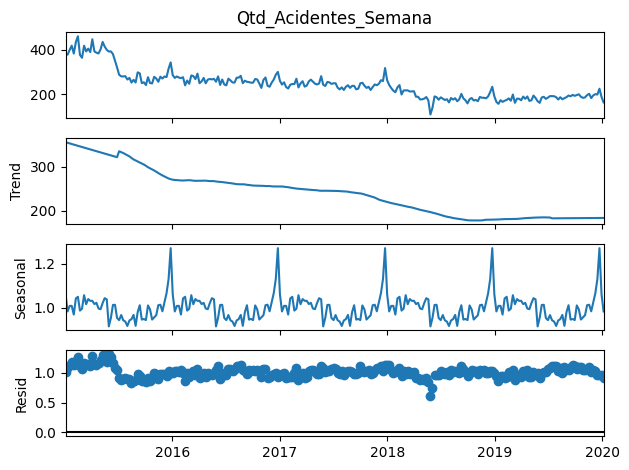

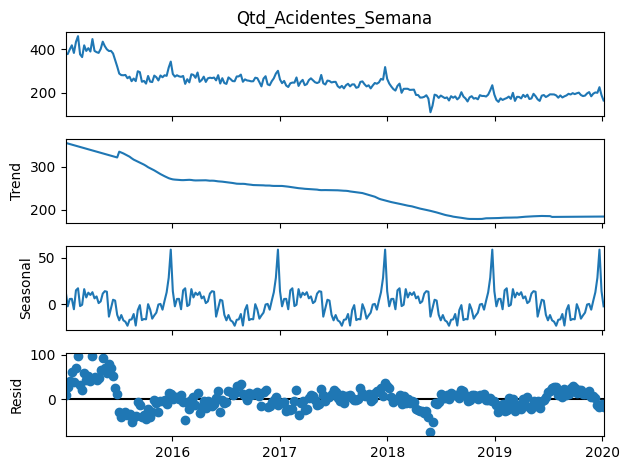

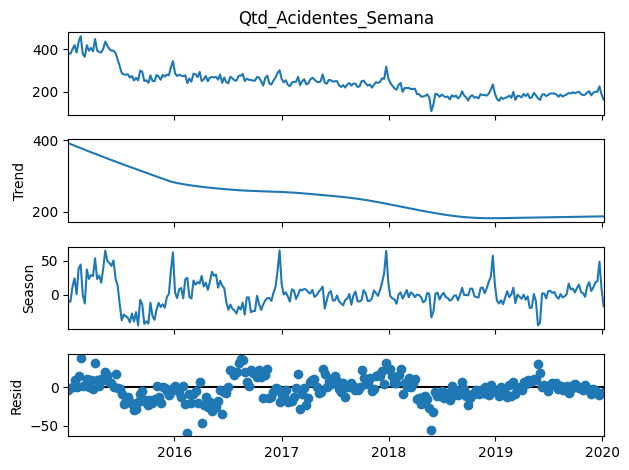

In [808]:
# Decomposições por adição
decomp_mult = seasonal_decompose(acd_sem['Qtd_Acidentes_Semana'],model = 'multiplicative', extrapolate_trend = 'freq', period = 52)
graf_mult = decomp_mult.plot()

# Decomposições por multiplicação
decomp_soma = seasonal_decompose(acd_sem['Qtd_Acidentes_Semana'],model = 'additive', extrapolate_trend = 'freq',period = 52)
graf_som = decomp_soma.plot()

# Decomposições por STL
decomp_stl = STL(acd_sem['Qtd_Acidentes_Semana']).fit()
graf_stl = decomp_stl.plot()

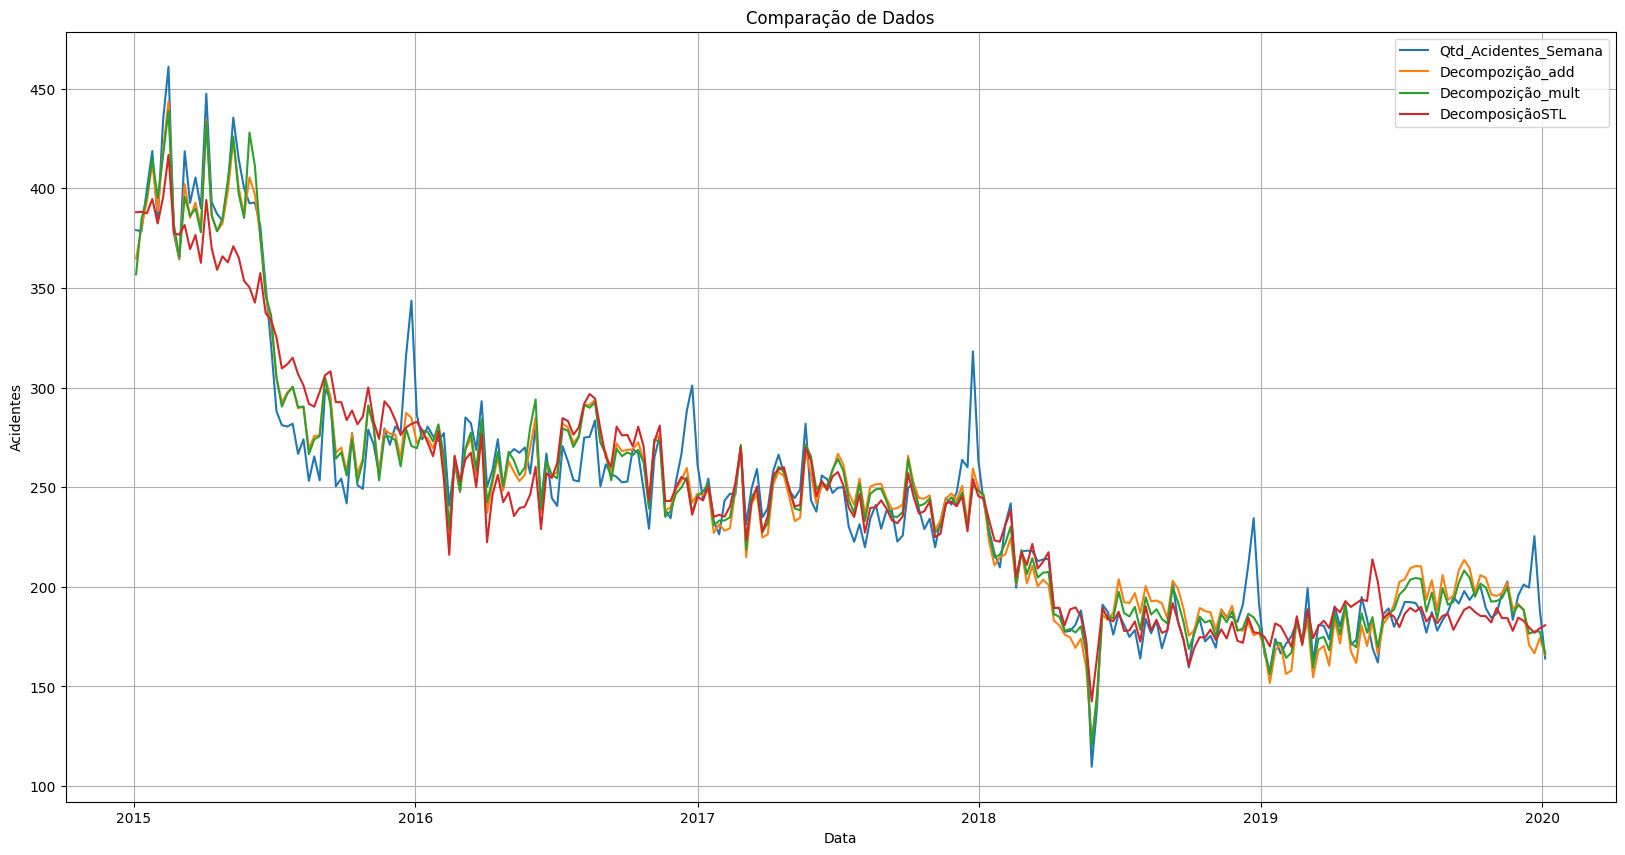

In [809]:
# Gerando série dessazonalizada para os três os métodos
acd_sem['Decompozição_add'] = acd_sem['Qtd_Acidentes_Semana'] - decomp_soma.seasonal
acd_sem['Decompozição_mult'] = acd_sem['Qtd_Acidentes_Semana']/decomp_mult.seasonal
acd_sem['Decompozição_STL'] = acd_sem['Qtd_Acidentes_Semana'] - decomp_stl.seasonal

# Gera um gráfico que mostra todos os resultados(Gráfico meio confuso, muita info junta, possível melhora)
plt.figure(figsize=(20, 10))
plt.plot(acd_sem['Qtd_Acidentes_Semana'], label='Qtd_Acidentes_Semana')
plt.plot(acd_sem['Decompozição_add'], label='Decompozição_add')
plt.plot(acd_sem['Decompozição_mult'], label='Decompozição_mult')
plt.plot(acd_sem['Decompozição_STL'], label='DecomposiçãoSTL')
plt.grid(True)
plt.title('Comparação de Dados')
plt.xlabel('Data')
plt.ylabel('Acidentes')
plt.legend()


- Agora a ideia é comparar os tres tipos de dessazonalização por medidas de erro, medidas de eficiencia de modelos. O pacote imporrtado acima possui já duas das fórmulas necessárias, uso elas e construo a do MAPE para que possa ser feita a comparação. 
- Breve descrição das medidas: 

- **Erro Absoluto Médio (MAE - Mean Absolute Error):**
   - O MAE é a média das diferenças absolutas entre os valores previstos e os valores observados. 
   - Ele fornece uma ideia da magnitude dos erros sem considerar sua direção (positivo ou negativo).
   - Quanto menor o MAE, melhor o desempenho do modelo. 

- **Raiz do Erro Quadrático Médio (RMSE - Root Mean Squared Error):**
   - O RMSE é a raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores observados.
   - Ele penaliza mais fortemente os erros maiores, pois eles são elevados ao quadrado antes de serem somados e então tirada a raiz quadrada.
   - Também fornece uma medida da dispersão dos erros.
   - Novamente, quanto menor o RMSE, melhor o desempenho do modelo.

- **Erro Percentual Absoluto Médio (MAPE - Mean Absolute Percentage Error):**
   - O MAPE é uma medida de precisão de previsão expressa como uma porcentagem.
   - Ele calcula a média das diferenças percentuais absolutas entre os valores previstos e os valores observados em relação aos valores observados.
   - É útil porque dá uma ideia da magnitude dos erros em termos percentuais em relação aos valores observados.
   - Como os outros indicadores, quanto menor o MAPE, melhor o desempenho do modelo.

Interpretar esses indicadores depende do contexto específico do problema e das unidades dos dados. Em geral, você gostaria que todos esses indicadores fossem o mais baixo possível, indicando que seu modelo está fazendo previsões precisas. No entanto, é importante considerar o contexto do problema para determinar qual métrica é mais relevante para sua avaliação. Por exemplo, o MAE pode ser mais fácil de interpretar em termos absolutos, enquanto o MAPE pode ser mais útil quando você precisa entender a precisão relativa das previsões em relação aos valores observados.

In [810]:
# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculando as métricas para a série dessazonalizada aditiva
mae_add = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add'])
rmse_add = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add']))
mape_add = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_add'])

# Calculando as métricas para a série dessazonalizada multiplicativa
mae_mult = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult'])
rmse_mult = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult']))
mape_mult = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_mult'])

# Calculando as métricas para a série dessazonalizada aditiva
mae_stl = mean_absolute_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL'])
rmse_stl = np.sqrt(mean_squared_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL']))
mape_stl = mean_absolute_percentage_error(acd_sem['Qtd_Acidentes_Semana'], acd_sem['Decompozição_STL'])

# Mostra as métricas de erro para comparação
print(f"Modelo Aditivo - MAE: {mae_add}, RMSE: {rmse_add}, MAPE: {mape_add}%")
print(f"Modelo Multiplicativo - MAE: {mae_mult}, RMSE: {rmse_mult}, MAPE: {mape_mult}%")
print(f"Modelo STL - MAE: {mae_stl}, RMSE: {rmse_stl}, MAPE: {mape_stl}%")

Modelo Aditivo - MAE: 11.212034888293084, RMSE: 14.59188432446982, MAPE: 4.839351648106115%
Modelo Multiplicativo - MAE: 9.856290361155006, RMSE: 13.778043484022916, MAPE: 4.03682996194708%
Modelo STL - MAE: 13.87589833791121, RMSE: 19.548567258791934, MAPE: 5.451959151243909%


Precisamos que esses erros tenham algum valor, uma vez que queremos uma série de fato diferente da original, ela deve suavizar os spikes decorrentes da sazonalidade, porém mantendo a característica original e fidedignidade à série. Em suma eles não podem ser zero mas continua válido o raciocínio de quanto menos melhor.
A escolha do modelo foi pelo de adição, uma vez que gera os menores indices num geral.

Com a série dessazonalizada podemos continuar com a progressão do trabalho e partir para a análise da estacionariedade da série, uma vez que o trabalho se apresenta como aplicação de modelos estacionários temos de garantir a estacionariedade da série para continuar.

In [811]:
# Criação do objeto que será usado para testes futuros
acddes_sem = acd_sem[['Decompozição_mult']].copy()
acddes_sem.head()

,Decompozição_mult
data_inversa,
2015-01-04,356.849847
2015-01-11,384.449821
2015-01-18,395.867792
2015-01-25,414.808661
2015-02-01,395.210642


In [812]:
# Os testes realizados serão ADF- aumentado, Philip-Perron e KPSS
# Todos os métodos aqui apresentados possuem dois argumentos que serão úteis: trend = "ct" e lags = , devemos fazer todos esses

adf = ADF(acddes_sem)
print(adf.summary().as_text())

adf = ADF(acddes_sem, trend="ct")
print(adf.summary().as_text())

dfgls = DFGLS(acddes_sem)
print(dfgls.summary().as_text())

dfgls = DFGLS(acddes_sem, trend="ct")
print(dfgls.summary().as_text())

pp = PhillipsPerron(acddes_sem)
print(pp.summary().as_text())

pp = PhillipsPerron(acddes_sem, trend="ct")
print(pp.summary().as_text())

kpss = KPSS(acddes_sem)#hipotese nula se inverte
print(kpss.summary().as_text())

kpss = KPSS(acddes_sem, trend="ct")
print(kpss.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.327
P-value                         0.163
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.753
P-value                         0.215
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                  0.043
P-value                         0.708
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -2.64 (1%), -2.0

Para interpretar os resultados dos testes de estacionaridade fornecidos, é importante entender a hipótese nula (H0) e a hipótese alternativa (H1) de cada teste:

1. **Augmented Dickey-Fuller (ADF) Test**:
   - **H0**: A série tem uma raiz unitária (não é estacionária).
   - **H1**: A série é fracamente estacionária (não tem raiz unitária).

2. **Dickey-Fuller GLS (DF-GLS) Test**:
   - **H0**: A série tem uma raiz unitária (não é estacionária).
   - **H1**: A série é fracamente estacionária (não tem raiz unitária).

3. **Phillips-Perron (PP) Test**:
   - **H0**: A série tem uma raiz unitária (não é estacionária).
   - **H1**: A série é fracamente estacionária (não tem raiz unitária).

4. **KPSS Test**:
   - **H0**: A série é fracamente estacionária (não tem raiz unitária).
   - **H1**: A série tem uma raiz unitária (não é estacionária).

### Resultados detalhados

#### Augmented Dickey-Fuller (ADF) Test
1. **Sem tendência**:
   - Test Statistic: -2.029
   - P-value: 0.274
   - Lags: 2
   - Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)

   A estatística de teste (-2.029) é maior que todos os valores críticos, e o p-valor (0.274) é maior que 0.05. Não rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

2. **Com tendência linear**:
   - Test Statistic: -2.700
   - P-value: 0.236
   - Lags: 2
   - Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)

   A estatística de teste (-2.700) é maior que todos os valores críticos, e o p-valor (0.236) é maior que 0.05. Não rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

#### Dickey-Fuller GLS (DF-GLS) Test
1. **Sem tendência**:
   - Test Statistic: 0.169
   - P-value: 0.749
   - Lags: 2
   - Critical Values: -2.64 (1%), -2.02 (5%), -1.71 (10%)

   A estatística de teste (0.169) é maior que todos os valores críticos, e o p-valor (0.749) é maior que 0.05. Não rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

2. **Com tendência linear**:
   - Test Statistic: -2.283
   - P-value: 0.182
   - Lags: 2
   - Critical Values: -3.49 (1%), -2.92 (5%), -2.63 (10%)

   A estatística de teste (-2.283) é maior que todos os valores críticos, e o p-valor (0.182) é maior que 0.05. Não rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

#### Phillips-Perron (PP) Test
1. **Sem tendência**:
   - Test Statistic: -1.896
   - P-value: 0.334
   - Lags: 16
   - Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)

   A estatística de teste (-1.896) é maior que todos os valores críticos, e o p-valor (0.334) é maior que 0.05. Não rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

2. **Com tendência linear**:
   - Test Statistic: -4.400
   - P-value: 0.002
   - Lags: 16
   - Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)

   A estatística de teste (-4.400) é menor que todos os valores críticos, e o p-valor (0.002) é menor que 0.05. Rejeitamos a hipótese nula, indicando que a série é estacionária.

#### KPSS Test
1. **Sem tendência**:
   - Test Statistic: 1.963
   - P-value: 0.000
   - Lags: 10
   - Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)

   A estatística de teste (1.963) é maior que todos os valores críticos, e o p-valor (0.000) é menor que 0.05. Rejeitamos a hipótese nula, indicando que a série tem uma raiz unitária (não é estacionária).

2. **Com tendência linear**:
   - Test Statistic: 0.213
   - P-value: 0.011
   - Lags: 10
   - Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)

   A estatística de teste (0.213) é maior que o valor crítico de 5% e 10%, mas menor que o valor crítico de 1%. Dependendo do nível de significância que consideramos, podemos rejeitar a hipótese nula em 5% e 10%, mas não em 1%, sugerindo que a série é marginalmente estacionária.

### Conclusão Geral
A maioria dos testes (ADF, DF-GLS, e KPSS sem tendência linear) indica que a série tem uma raiz unitária (não é estacionária). Apenas o teste Phillips-Perron com tendência linear rejeita a hipótese nula, sugerindo que a série é estacionária com uma tendência linear. 

Portanto, a evidência predominante sugere que a série não é estacionária. Pode ser necessário aplicar transformações adicionais, como diferenciação, para tornar a série estacionária antes de usar modelos que assumem estacionaridade.

Uma coisa que vi na documentação do pacote:
- The ADF assumes residuals are white noise, and that the number of lags is sufficient to pick up any dependence in the data.

<span style="line-height: 2;"><font size="3"><b>Diferenciação da Série Temporal Semanal: </font></b> Percebemos que a série temporal semanal exibe uma
leve tendência, o que a torna não estacionária pois sua média e variância não serão constantes ao longo do tempo. Isso é um problema para nós pois, como citado anteriormente, o modelo ARIMA exige que a série seja estacionária. A fim de tentar torná-la estacionária, podemos usar a primeira diferença dela, o que, em termos práticos, significa que geraremos uma nova série diferenciada em que cada valor corresponde à diferença entre o valor da observação no período <b>t</b> e o valor da observação no período <b>t-1</b>. </span><br> 

<span style="line-height: 2;">Traçando o gráfico da série diferenciada, observamos que, aparentemente, ela é estacionária como queriamos. Para checar se isso é verdade, podemos utilizar o Teste de Dickey-Fuller Aumentado.</span><br>

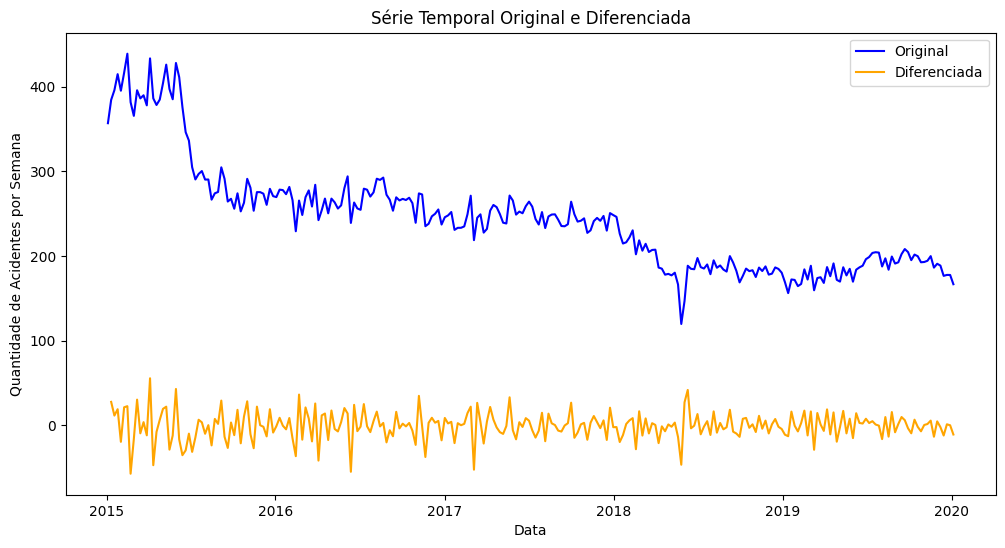

In [813]:
#1a Diferenciação da Série Temporal
acddes_sem['Qtd_Acidentes_Semana_1stDiff'] = acddes_sem['Decompozição_mult'].diff()
acddes_sem = acddes_sem.drop("Decompozição_mult",axis=1)
acddes_sem = acddes_sem.iloc[1:]

#Gráfico da série temporal original
plt.figure(figsize=(12, 6))
plt.plot(acd_sem['Decompozição_mult'], label='Original', color='blue')

# Criar um gráfico de linha para a série temporal diferenciada
plt.plot(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], label='Diferenciada', color='orange')
plt.title('Série Temporal Original e Diferenciada')
plt.xlabel('Data')
plt.ylabel('Quantidade de Acidentes por Semana')
plt.legend()
plt.show()


<span style="line-height: 2;"><font size="3"><b>Teste de Estacionariedade de Dickey-Fuller (ADF): </font></b> Esse teste de estacionariedade é baseado no fato de que caso uma série temporal seja não-estacionária, então ela terá uma raiz unitária. Isso significa que, nessa circunstância, o coeficiente do primeiro lag da variável de série temporal será 1, de modo que a série temporal se comportará como um passeio aleatório. Assim, o teste de estacionariedade basicamente serve para testarmos a hipótese de que o coeficiente do primeiro lag é unitário. Por exemplo, considere que Y representa o número de acidentes semanais, logo: <br> 

$$Y_t = \beta_0 + \beta_1Y_{t-1} + \epsilon_t$$

Primeira diferença: $$Y_t - Y_{t-1} = \beta_0 + \beta_1Y_{t-1} - Y_{t-1} + \epsilon_t$$
$$Y_t - Y_{t-1} = \beta_0 + Y_{t-1}(\beta_1 - 1) + \epsilon_t$$
$$\Delta Y_t = \beta_0 + Y_{t-1}(\beta_1 - 1) + \epsilon_t$$
$$\Delta Y_t = \beta_0 + \delta Y_{t-1} + \epsilon_t$$
onde $$\delta = \beta_1 - 1$$
<br>

<span style="line-height: 2;">Assim, o teste de hipótese consiste em:<br>
$$H_0: \beta_1 = 1 \Leftrightarrow \delta = 0\ (não-estacionariedade)$$
$$H_a: \beta_1 < 1 \Leftrightarrow \delta < 0$$

<span style="line-height: 2;">É por isso que, quanto mais negativa for a estatística do teste ADF, mais evidência temos contra a hipótese de não estacionariedade, logo, mais certo podemos estar sobre a série temporal analisada ser estacionária e poder, portanto, ser modelada com um modelo ARIMA após a primeira diferenciação. No nosso caso, por termos uma estatística ADF bastante negativa (-9,43) e um p-valor extremamente baixo (o que confirma que ADF é estatisticamente significante em todos os níveis de significância usuais), concluímos a rejeição da hipótese nula de não-estacionariedade da série temporal primeiramente diferenciada em questão, concluindo que ela é, nesse sentido, estacionária.


In [814]:
acddes_sem.info()
acddes_sem.head

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-01-11 to 2020-01-05
Freq: W-SUN
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Qtd_Acidentes_Semana_1stDiff  261 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


<bound method NDFrame.head of               Qtd_Acidentes_Semana_1stDiff
data_inversa                              
2015-01-11                       27.599974
2015-01-18                       11.417970
2015-01-25                       18.940870
2015-02-01                      -19.598019
2015-02-08                       21.200648
...                                    ...
2019-12-08                       -2.188373
2019-12-15                      -12.122074
2019-12-22                        1.111912
2019-12-29                       -0.043171
2020-01-05                      -10.941186

[261 rows x 1 columns]>

In [815]:
# Os testes realizados serão ADF- aumentado, Philip-Perron e KPSS
# Todos os métodos aqui apresentados possuem dois argumentos que serão úteis: trend = "ct" e lags = , devemos fazer todos esses
adf = ADF(acddes_sem)
print(adf.summary().as_text())

adf = ADF(acddes_sem, trend="ct")
print(adf.summary().as_text())

dfgls = DFGLS(acddes_sem)
print(dfgls.summary().as_text())

dfgls = DFGLS(acddes_sem, trend="ct")
print(dfgls.summary().as_text())

pp = PhillipsPerron(acddes_sem)
print(pp.summary().as_text())

pp = PhillipsPerron(acddes_sem, trend="ct")
print(pp.summary().as_text())

kpss = KPSS(acddes_sem)#hipotese nula se inverte
print(kpss.summary().as_text())

kpss = KPSS(acddes_sem, trend="ct")
print(kpss.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -16.945
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                -10.523
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                 -4.662
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -2.64 (1%), -2.0

Vamos interpretar novamente os resultados dos testes de raiz unitária e estacionaridade que você forneceu:

### Testes de Dickey-Fuller Aumentado (ADF)

1. **ADF com Tendência Constante**
   - **Estatística do teste:** -16.945
   - **P-valor:** 0.000
   - **Lags:** 1
   - **Valores críticos:**
     - 1%: -3.46
     - 5%: -2.87
     - 10%: -2.57
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária (não estacionária).
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** Como a estatística do teste (-16.945) é menor que todos os valores críticos e o p-valor é 0.000 (menor que qualquer nível de significância usual), rejeitamos a hipótese nula. Portanto, a série é estacionária com tendência constante.

2. **ADF com Tendência Constante e Linear**
   - **Estatística do teste:** -10.523
   - **P-valor:** 0.000
   - **Lags:** 3
   - **Valores críticos:**
     - 1%: -3.99
     - 5%: -3.43
     - 10%: -3.14
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária.
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** Similarmente, a estatística do teste (-10.523) é menor que todos os valores críticos e o p-valor é 0.000, indicando que a hipótese nula é rejeitada. A série é estacionária com tendência constante e linear.

### Testes de Dickey-Fuller GLS (DF-GLS)

1. **DF-GLS com Tendência Constante**
   - **Estatística do teste:** -4.662
   - **P-valor:** 0.000
   - **Lags:** 1
   - **Valores críticos:**
     - 1%: -2.64
     - 5%: -2.02
     - 10%: -1.71
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária.
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** A estatística do teste (-4.662) é menor que todos os valores críticos e o p-valor é 0.000, indicando que a hipótese nula é rejeitada. A série é estacionária com tendência constante.

2. **DF-GLS com Tendência Constante e Linear**
   - **Estatística do teste:** -8.122
   - **P-valor:** 0.000
   - **Lags:** 1
   - **Valores críticos:**
     - 1%: -3.49
     - 5%: -2.92
     - 10%: -2.63
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária.
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** A estatística do teste (-8.122) é menor que todos os valores críticos e o p-valor é 0.000, indicando que a hipótese nula é rejeitada. A série é estacionária com tendência constante e linear.

### Testes de Phillips-Perron (PP)

1. **PP com Tendência Constante**
   - **Estatística do teste:** -25.526
   - **P-valor:** 0.000
   - **Lags:** 16
   - **Valores críticos:**
     - 1%: -3.46
     - 5%: -2.87
     - 10%: -2.57
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária.
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** A estatística do teste (-25.526) é menor que todos os valores críticos e o p-valor é 0.000, indicando que a hipótese nula é rejeitada. A série é estacionária com tendência constante.

2. **PP com Tendência Constante e Linear**
   - **Estatística do teste:** -26.026
   - **P-valor:** 0.000
   - **Lags:** 16
   - **Valores críticos:**
     - 1%: -3.99
     - 5%: -3.43
     - 10%: -3.14
   - **Hipóteses:**
     - **H0:** A série contém uma raiz unitária.
     - **H1:** A série é fracamente estacionária.

   **Interpretação:** A estatística do teste (-26.026) é menor que todos os valores críticos e o p-valor é 0.000, indicando que a hipótese nula é rejeitada. A série é estacionária com tendência constante e linear.

### Testes KPSS

1. **KPSS com Tendência Constante**
   - **Estatística do teste:** 0.065
   - **P-valor:** 0.786
   - **Lags:** 17
   - **Valores críticos:**
     - 1%: 0.74
     - 5%: 0.46
     - 10%: 0.35
   - **Hipóteses:**
     - **H0:** A série é fracamente estacionária.
     - **H1:** A série contém uma raiz unitária.

   **Interpretação:** A estatística do teste (0.065) é menor que todos os valores críticos e o p-valor é 0.786, indicando que não rejeitamos a hipótese nula. Portanto, a série é fracamente estacionária com tendência constante.

2. **KPSS com Tendência Constante e Linear**
   - **Estatística do teste:** 0.039
   - **P-valor:** 0.731
   - **Lags:** 18
   - **Valores críticos:**
     - 1%: 0.22
     - 5%: 0.15
     - 10%: 0.12
   - **Hipóteses:**
     - **H0:** A série é fracamente estacionária.
     - **H1:** A série contém uma raiz unitária.

   **Interpretação:** A estatística do teste (0.039) é menor que todos os valores críticos e o p-valor é 0.731, indicando que não rejeitamos a hipótese nula. Portanto, a série é fracamente estacionária com tendência constante e linear.

### Conclusão Geral

Os resultados dos testes ADF, DF-GLS e Phillips-Perron indicam que a série é estacionária, pois rejeitamos a hipótese nula de raiz unitária (não estacionária) em todos os casos. Os testes KPSS confirmam essa conclusão, pois não rejeitamos a hipótese nula de estacionariedade.

Portanto, a série é estacionária sob as várias especificações de tendência e métodos de teste aplicados.

Cada um desses testes de raiz unitária tem suas características específicas, vantagens e desvantagens, que podem torná-los mais ou menos apropriados dependendo da situação.

### 1. **Dickey-Fuller Aumentado (ADF)**
- **Vantagens**:
  - É um dos testes de raiz unitária mais utilizados e bem compreendidos.
  - Permite a inclusão de termos de tendência (constante e tendência linear).
- **Desvantagens**:
  - Pode ser sensível à escolha do número de defasagens.
  - Menos poderoso (ou seja, menos provável de detectar estacionariedade) em comparação com outros testes como o Phillips-Perron.

### 2. **Dickey-Fuller GLS (Generalized Least Squares)**
- **Vantagens**:
  - Uma versão aprimorada do ADF, ajustando a série antes do teste para melhorar o poder estatístico.
  - Pode ser mais potente que o ADF padrão, especialmente em séries com tendências fortes.
- **Desvantagens**:
  - Ainda pode ser sensível à escolha do número de defasagens.

### 3. **Phillips-Perron (PP)**
- **Vantagens**:
  - Menos sensível à escolha do número de defasagens em comparação com o ADF.
  - Ajusta automaticamente para a heterocedasticidade e correlação serial nas perturbações.
- **Desvantagens**:
  - Pode ser menos robusto na presença de quebras estruturais na série temporal.

### 4. **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**
- **Vantagens**:
  - Testa a hipótese nula de estacionariedade ao contrário do ADF e PP que testam a hipótese nula de raiz unitária.
  - Útil para confirmar resultados de outros testes de raiz unitária.
- **Desvantagens**:
  - Pode ser muito sensível a autocorrelações de alta ordem e heterocedasticidade.
  - Rejeições da hipótese nula podem ocorrer devido à presença de tendências de longo prazo.

### Escolha do Teste
A escolha do teste depende do contexto específico e das características da série temporal que você está analisando:

1. **Compreensão e Familiaridade**: Se você está começando com a análise de séries temporais, o ADF é um bom ponto de partida devido à sua popularidade e documentação disponível.
2. **Presença de Tendências**: Se a série tem tendências fortes, o Dickey-Fuller GLS pode ser mais apropriado.
3. **Correlação Serial e Heterocedasticidade**: Se houver suspeita de correlação serial ou heterocedasticidade, o Phillips-Perron pode ser mais robusto.
4. **Confirmação de Estacionariedade**: O KPSS é útil para confirmar os resultados de outros testes, especialmente quando os resultados dos testes de raiz unitária são ambíguos.

### Estratégia Recomendada
Uma abordagem prática é usar uma combinação desses testes para obter uma visão mais completa:

1. **Iniciar com ADF ou ADF-GLS**: Para uma primeira verificação da estacionariedade.
2. **Usar Phillips-Perron**: Para confirmar os resultados e lidar com potenciais problemas de correlação serial e heterocedasticidade.
3. **Aplicar KPSS**: Para verificar a estacionariedade diretamente e confirmar os resultados obtidos dos testes de raiz unitária.

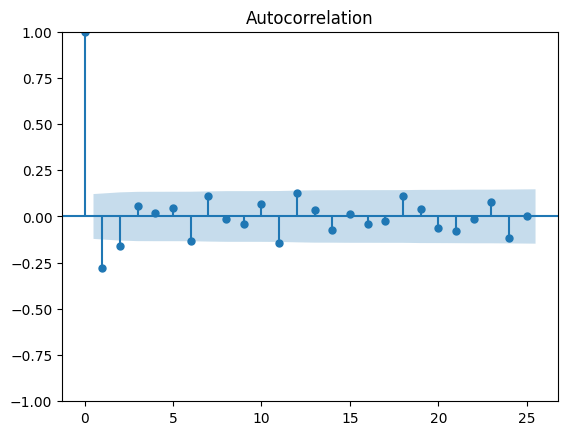

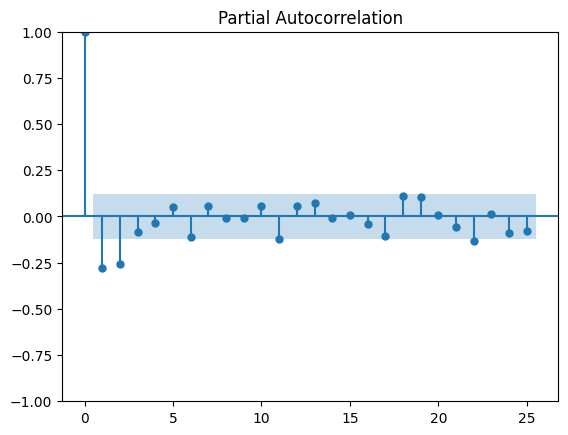

In [816]:
#Autocorrelação
plot_acf(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], lags=25) 
plot_pacf(acddes_sem['Qtd_Acidentes_Semana_1stDiff'], lags=25) 
plt.show()

In [817]:
#Proporção de dados de treino vs teste de 90/10
acd_arima = acddes_sem['Qtd_Acidentes_Semana_1stDiff'].copy()
divisao = int(np.round(len(acd_arima)*0.1))

acd_treino = acd_arima.iloc[:-divisao]
acd_teste = acd_arima.iloc[-divisao:]

#Shapes
print("Shape do DF original:", acd_arima.shape)
print("Shape dos DFs de treino:", acd_treino.shape)
print("Shape dos DFs de teste:", acd_teste.shape)


Shape do DF original: (261,)
Shape dos DFs de treino: (235,)
Shape dos DFs de teste: (26,)


In [818]:
#Modelagem 
modelo = sm.tsa.arma_order_select_ic(acd_treino,ic=["aic", "bic","hqic"], max_ma=2, max_ar=2)

In [819]:
# O objeto resultado é um Bunch
print(type(modelo))  

# Acessando os diferentes elementos
print("AIC:")
print(modelo.aic)

print("\nBIC:")
print(modelo.bic)

print("\nHQIC:")
print(modelo.hqic)

print("\nOrdem do modelo com menor AIC:")
print(modelo.aic_min_order)

print("\nOrdem do modelo com menor BIC:")
print(modelo.bic_min_order)

print("\nOrdem do modelo com menor HQIC:")
print(modelo.hqic_min_order)

<class 'statsmodels.tools.tools.Bunch'>
AIC:
             0            1            2
0  2004.155744  1972.717530  1970.333528
1  1987.336820  1971.716561  1970.526546
2  1971.643367  1970.897916  1972.525553

BIC:
             0            1            2
0  2011.074915  1983.096286  1984.171870
1  1997.715577  1985.554903  1987.824474
2  1985.481709  1988.195843  1993.283066

HQIC:
             0            1            2
0  2006.945235  1976.901767  1975.912511
1  1991.521058  1977.295544  1977.500275
2  1977.222350  1977.871644  1980.894027

Ordem do modelo com menor AIC:
(0, 2)

Ordem do modelo com menor BIC:
(0, 1)

Ordem do modelo com menor HQIC:
(0, 2)


In [820]:
# Ajustando o modelo sugerido pelo BIC
modelo_bic = sm.tsa.ARIMA(acd_treino, order=(0,0, 1)).fit()
print("Resumo do modelo BIC:")
print(modelo_bic.summary())

# Comparando o AIC e BIC dos modelos ajustados
print("\nComparação dos Modelos:")
print(f"Modelo AIC - AIC: {modelo_aic.aic}, BIC: {modelo_aic.bic}")
print(f"Modelo BIC - AIC: {modelo_bic.aic}, BIC: {modelo_bic.bic}")

Resumo do modelo BIC:
                                    SARIMAX Results                                     
Dep. Variable:     Qtd_Acidentes_Semana_1stDiff   No. Observations:                  235
Model:                           ARIMA(0, 0, 1)   Log Likelihood                -983.359
Date:                          Wed, 05 Jun 2024   AIC                           1972.718
Time:                                  13:06:28   BIC                           1983.096
Sample:                              01-11-2015   HQIC                          1976.902
                                   - 07-07-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7623      0.574     -1.327      0.184      -1.888       0.363
ma.L1         -0.4599      0.

### Resumo Geral
- **Dep. Variable**: A variável dependente é `Qtd_Acidentes_Semana_1stDiff`, ou seja, a quantidade de acidentes semanais diferenciada uma vez.
- **No. Observations**: 235 observações foram usadas no ajuste do modelo.
- **Model**: ARIMA(0, 0, 1), indicando que este é um modelo de média móvel de ordem 1 (MA(1)) sem partes autoregressivas e sem diferenciação adicional.
- **Log Likelihood**: -983.359, uma medida da probabilidade do modelo dado os dados.
- **AIC (Akaike Information Criterion)**: 1972.718, usado para comparar modelos - valores mais baixos indicam um melhor ajuste.
- **BIC (Bayesian Information Criterion)**: 1983.096, similar ao AIC, mas penaliza mais por modelos mais complexos.
- **HQIC (Hannan-Quinn Information Criterion)**: 1976.902, outro critério de informação para seleção de modelos.

### Coeficientes do Modelo
- **const**: -0.7623, mas não é estatisticamente significativo (P>|z| = 0.184). Isso sugere que a constante não difere significativamente de zero.
- **ma.L1**: -0.4599, o coeficiente para a parte MA(1), que é altamente significativo (P>|z| = 0.000). Um valor negativo indica que há um efeito negativo no valor presente da série a partir do valor anterior da média móvel.
- **sigma2**: 252.1756, a variância do erro, também altamente significativa (P>|z| = 0.000).

### Testes de Diagnóstico
- **Ljung-Box (L1) (Q)**: 1.02 com uma probabilidade associada de 0.31. Isso sugere que não há evidência de autocorrelação nos resíduos do modelo.
- **Jarque-Bera (JB)**: 15.51 com uma probabilidade associada de 0.00, indicando que os resíduos não seguem uma distribuição normal (indicando possíveis outliers ou erros não normalmente distribuídos).
- **Heteroskedasticity (H)**: 0.36 com uma probabilidade associada de 0.00, sugerindo que há heterocedasticidade (variância não constante) nos resíduos.

### Observações Adicionais
- **Skew**: -0.30, indicando que os resíduos têm uma leve assimetria negativa.
- **Kurtosis**: 4.11, maior que 3, sugerindo que os resíduos têm caudas mais pesadas do que uma distribuição normal (leptocúrtica).

### Conclusões
1. **Modelo Adequado**: O modelo MA(1) parece ser adequado para capturar a dinâmica dos dados, dada a significância do coeficiente `ma.L1`.
2. **Problemas com Resíduos**: A não normalidade e a heterocedasticidade nos resíduos sugerem que podem haver melhorias a serem feitas no modelo, como considerar transformações ou modelos que capturem a variabilidade condicional dos erros.
3. **Comparação de Modelos**: Valores de AIC, BIC e HQIC são úteis para comparar diferentes modelos ARIMA. Um modelo com valores mais baixos desses critérios é preferível.

In [821]:
# Ajustando o modelo sugerido pelo AIC
modelo_aic = sm.tsa.ARIMA(acd_treino, order=(0,0, 2)).fit()
print("Resumo do modelo AIC:")
print(modelo_aic.summary())


Resumo do modelo AIC:
                                    SARIMAX Results                                     
Dep. Variable:     Qtd_Acidentes_Semana_1stDiff   No. Observations:                  235
Model:                           ARIMA(0, 0, 2)   Log Likelihood                -981.167
Date:                          Wed, 05 Jun 2024   AIC                           1970.334
Time:                                  13:06:28   BIC                           1984.172
Sample:                              01-11-2015   HQIC                          1975.913
                                   - 07-07-2019                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7927      0.508     -1.560      0.119      -1.789       0.203
ma.L1         -0.3769      0.

### Resumo Geral
- **Dep. Variable**: Qtd_Acidentes_Semana_1stDiff, a quantidade de acidentes semanais diferenciada uma vez.
- **No. Observations**: 235 observações foram usadas no ajuste do modelo.
- **Model**: ARIMA(0, 0, 2), um modelo de média móvel de ordem 2 (MA(2)).
- **Log Likelihood**: -981.167, indicando uma ligeira melhoria em relação ao modelo MA(1).
- **AIC (Akaike Information Criterion)**: 1970.334, menor que o AIC do modelo MA(1) (1972.718), sugerindo um melhor ajuste.
- **BIC (Bayesian Information Criterion)**: 1984.172, um pouco maior que o BIC do modelo MA(1) (1983.096), o que pode indicar que o ganho em ajuste pode não justificar a maior complexidade do modelo.
- **HQIC (Hannan-Quinn Information Criterion)**: 1975.913, menor que o HQIC do modelo MA(1) (1976.902), sugerindo um ajuste ligeiramente melhor.

### Coeficientes do Modelo
- **const**: -0.7927, não é estatisticamente significativo (P>|z| = 0.119), similar ao coeficiente constante do modelo MA(1).
- **ma.L1**: -0.3769, altamente significativo (P>|z| = 0.000), indicando um efeito negativo significativo da primeira componente de média móvel.
- **ma.L2**: -0.1445, também significativo (P>|z| = 0.014), adicionando um efeito da segunda componente de média móvel.
- **sigma2**: 247.4943, a variância do erro, altamente significativa (P>|z| = 0.000).

### Testes de Diagnóstico
- **Ljung-Box (L1) (Q)**: 0.00 com uma probabilidade associada de 0.95, indicando que não há evidência de autocorrelação nos resíduos do modelo, uma melhora em relação ao modelo MA(1).
- **Jarque-Bera (JB)**: 13.53 com uma probabilidade associada de 0.00, indicando que os resíduos não seguem uma distribuição normal (similar ao modelo MA(1)).
- **Heteroskedasticity (H)**: 0.36 com uma probabilidade associada de 0.00, sugerindo a presença de heterocedasticidade nos resíduos (mesma observação do modelo MA(1)).

### Observações Adicionais
- **Skew**: -0.29, indicando uma leve assimetria negativa, similar ao modelo MA(1).
- **Kurtosis**: 4.02, indicando caudas mais pesadas do que uma distribuição normal, similar ao modelo MA(1).

### Conclusões
1. **Melhoria no Ajuste**: O modelo MA(2) parece ajustar melhor os dados do que o modelo MA(1), como indicado pelo menor AIC e HQIC.
2. **Coeficientes Significativos**: Ambos os coeficientes de média móvel (ma.L1 e ma.L2) são significativos, sugerindo que a adição de uma segunda componente MA melhora o modelo.
3. **Resíduos**: Apesar de melhorar o ajuste, o modelo MA(2) ainda apresenta problemas de normalidade nos resíduos e heterocedasticidade, assim como o modelo MA(1).
4. **Autocorrelação dos Resíduos**: A ausência de autocorrelação nos resíduos (Ljung-Box) é uma melhoria importante em relação ao modelo MA(1).

### Comparação dos Modelos
- **MA(1)**: Menos complexo, mas com alguns sinais de autocorrelação residual.
- **MA(2)**: Melhor ajuste e sem autocorrelação residual, mas a complexidade aumentada (um coeficiente adicional) deve ser considerada.

Em resumo, o modelo MA(2) oferece um melhor ajuste aos dados e resolve o problema de autocorrelação residual presente no modelo MA(1). No entanto, ambos os modelos apresentam problemas de normalidade e heterocedasticidade nos resíduos. A escolha final entre os modelos pode depender do balanceamento entre ajuste e complexidade, bem como da consideração de possíveis melhorias ou transformações adicionais para lidar com a heterocedasticidade e a não normalidade dos resíduos.

## Analisando graficamente os Residuos

Como dito anteriormente, a análise dos residuos tem como objetivo verificar se existe informação ainda a ser capturada por modelagem. Caso o resíduo se comportar como um Ruído Branco, ou seja, como um série totalmente estocástica, significa que não podemos mais extrair informações da base já que tudo que não foi modelado e que foi para o erro, está se comportando de forma totalmente aleatória.


-   Plotando o comportamento dos resíduos e a partir de uma sequência de gráficos para poder inspecionar visualmente a normalidade e o comportamento dos erros num geral:

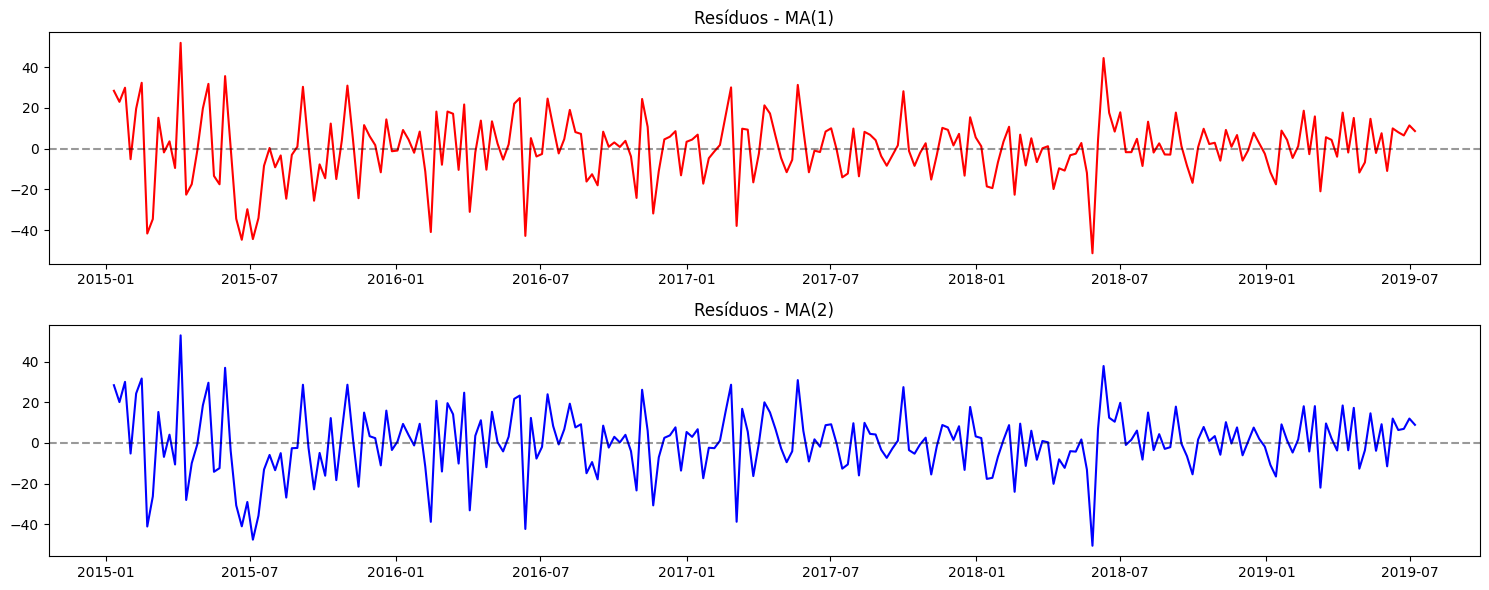

In [822]:
# obtendo os residuos dos modelos
residuos_MA1 = modelo_bic.resid
residuos_MA2 = modelo_aic.resid

# plotando o comportamento dos residuos conforme o tempo
# Configurando o tamanho da figura
plt.figure(figsize=(15, 6))

# Plotando o comportamento dos resíduos do MA(1)
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, primeiro gráfico
plt.plot(residuos_MA1, color='red')
plt.title('Resíduos - MA(1)')
plt.axhline(y=0, linestyle='--', color='black', alpha=0.4)

# Plotando o comportamento dos resíduos do MA(2)
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, primeiro gráfico
plt.plot(residuos_MA2, color='blue')
plt.title('Resíduos - MA(2)')
plt.axhline(y=0, linestyle='--', color='black', alpha=0.4)


# Ajustando o layout
plt.tight_layout()

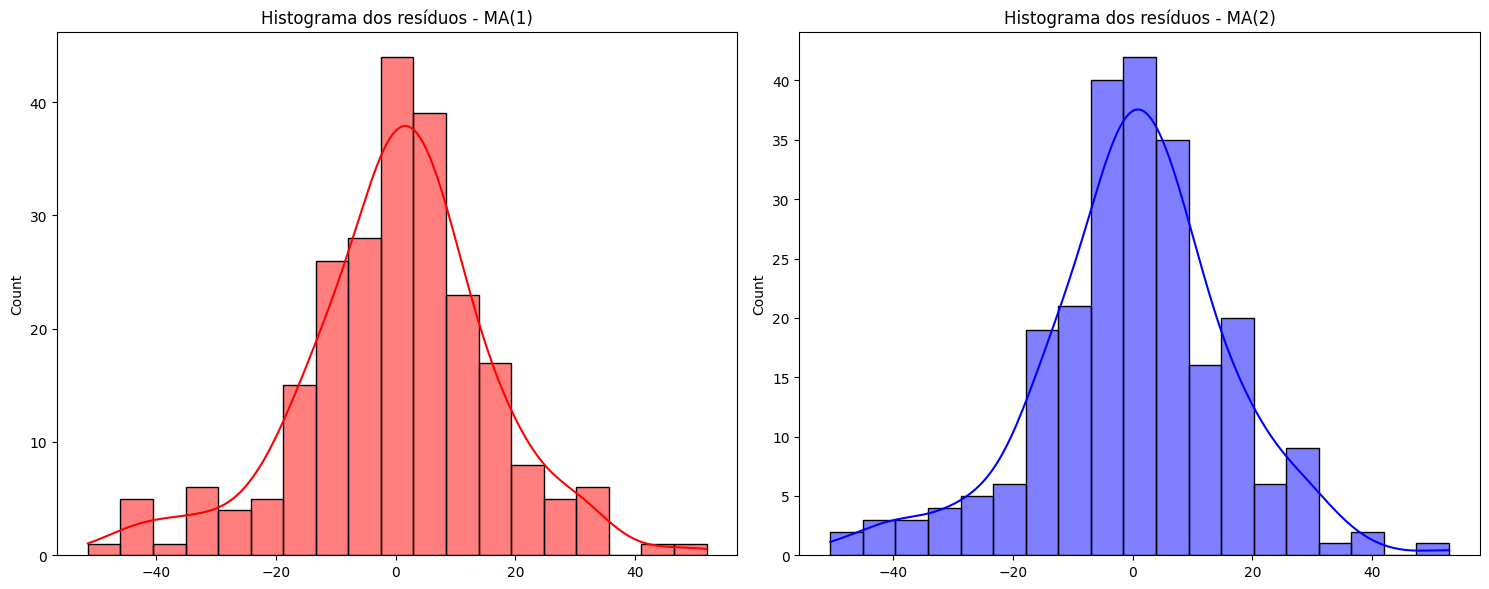

In [799]:
# Configurando o tamanho da figura
plt.figure(figsize=(15, 6))

# Plotando o histograma dos resíduos do MA(1)
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico
sns.histplot(residuos_MA1, kde=True, color='red')
plt.title('Histograma dos resíduos - MA(1)')

# Plotando o histograma dos resíduos do MA(2)
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico
sns.histplot(residuos_MA2, kde=True, color='blue')
plt.title('Histograma dos resíduos - MA(2)')

# Ajustando o layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()

-   Gráfico Q-Q dos resíduos

>O Gráfico Q-Q (Quantile-Quantile) compara os quantis esperados de uma distribuição normal com os quantis observados dos resíduos.
Ele ajuda a verificar se os resíduos seguem uma distribuição normal a partir da distancia entre os pontos plotados a partir da linha reta. Se os pontos no gráfico estiverem próximos de uma linha reta, isso sugere que os resíduos têm uma distribuição aproximadamente normal.

c:\Users\DESKTOP 15\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\graphics\gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


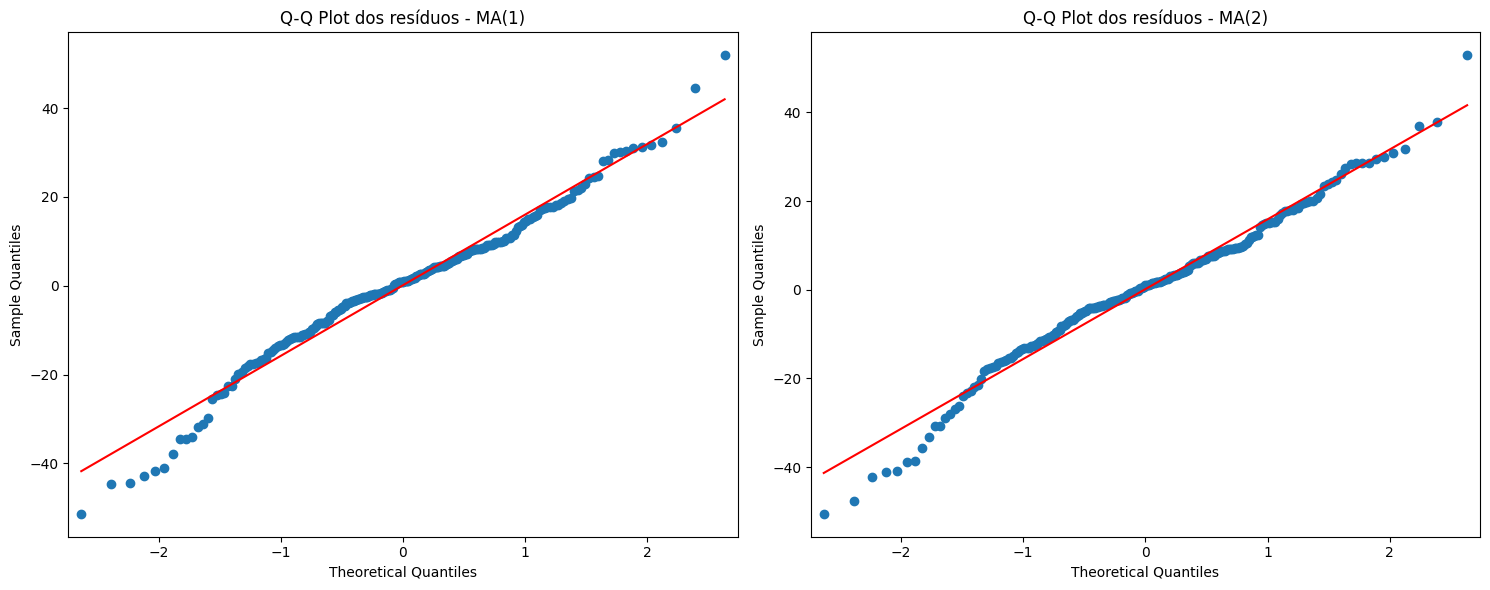

In [800]:
# Configurando o tamanho da figura
plt.figure(figsize=(15, 6))

# Plotando o q-q dos resíduos do MA(1)
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro grafico
sm.qqplot(residuos_MA1, line='s', ax=plt.gca(), color='red')
plt.title('Q-Q Plot dos resíduos - MA(1)')

# Plotando o q-q dos resíduos do MA(2)
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo grafico
sm.qqplot(residuos_MA2, line='s', ax=plt.gca(), color='blue')
plt.title('Q-Q Plot dos resíduos - MA(2)')

# Ajustando o layout e exibindo os gráficos
plt.tight_layout()
plt.show()


##### Primeira analise do Fit do modelo

Vemos a partir das séries fitadas que as diferenças entre os modelos MA(1) e MA(2) aplicadas são realativamente pequenas quando olhamos apenas para eles. Contudo, ao coloca-los em perspectiva à série efetiva, vemos que os modelos se encaixam pouco aos dados. Sugerindo que possa existir parte de informação não capturada pelo modelo e para verificarmos isso, precisamos analisar os resíduos e verificar se ele é um ruído branco, caso não seja, significa que uma parcela não estocástica da série ainda não foi modelada.

<br>

## Aplicação do Método de Rolling Forecast

O **Rolling Forecast** envolve planejamento dinâmico e ajustes contínuos com base em dados em tempo real. Em outras palavras, é um método computacional que se utiliza de iteradores para poder realizar <span style="color:red;">previsões</span> futuras com base nos dados previstos ou, como foi feito nesse caso, para testar a performance de modelos de previsão.


<br>

-   Implementação:
>O conjunto de treinamento é ajustado a cada iteração, excluindo o período de teste atual.
>Um modelo ARIMA com ordem (0, 0, 1) é ajustado aos dados de treinamento.
>A previsão é realizada para um passo à frente (um ponto no futuro).
>As previsões são armazenadas na lista rolling_predictions.


C:\Users\DESKTOP 15\AppData\Local\Temp\ipykernel_17412\3352436191.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_MA1 = modelo_fitado_MA1.forecast(steps=1)[0]
C:\Users\DESKTOP 15\AppData\Local\Temp\ipykernel_17412\3352436191.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_MA2 = modelo_fitado_MA2.forecast(steps=1)[0]
C:\Users\DESKTOP 15\AppData\Local\Temp\ipykernel_17412\3352436191.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

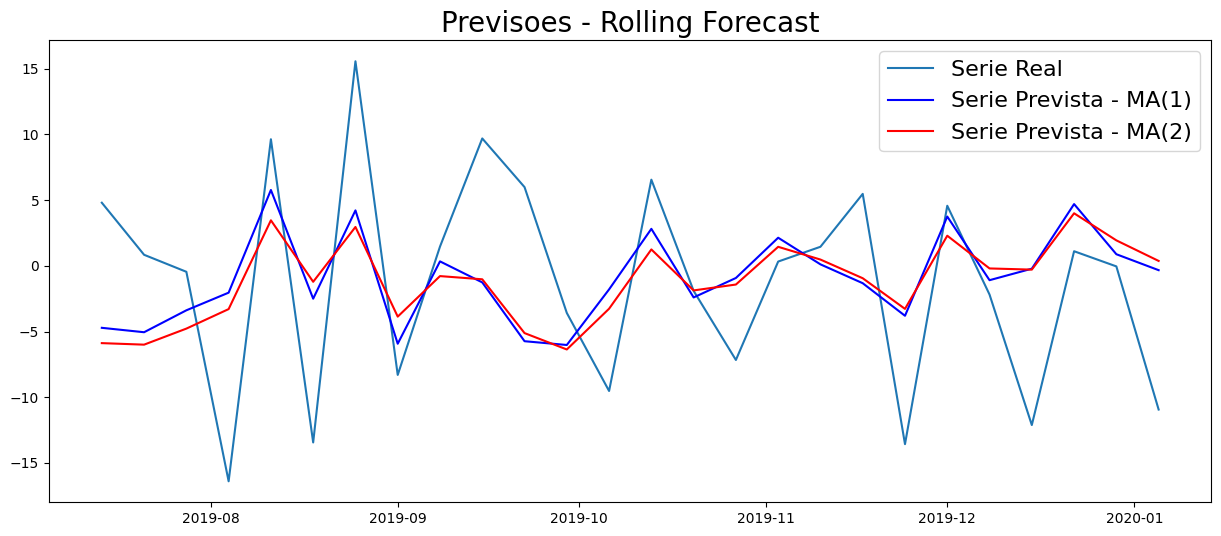

In [801]:
rolling_predictions_MA1 = []
rolling_predictions_MA2 = []
tamanho_teste = len(acd_teste)

for i in range(tamanho_teste):
    # Definindo o conjunto de treinamento a cada iteracao
    train = acddes_sem[:-(tamanho_teste-i)]
    
    # Ajustando o modelo ARIMA com os dados de treinamento
    modelo_MA1 = sm.tsa.ARIMA(train, order=(0, 0, 1)) # MA(1)
    modelo_MA2 = sm.tsa.ARIMA(train, order=(0, 0, 2)) # MA(2)
    
    # encaixando o modelo nos dados
    modelo_fitado_MA1 = modelo_MA1.fit() # MA(1)
    modelo_fitado_MA2 = modelo_MA2.fit() # MA(2)
    
    # Realizando a previsao 1 periodo pra frente
    pred_MA1 = modelo_fitado_MA1.forecast(steps=1)[0]  
    pred_MA2 = modelo_fitado_MA2.forecast(steps=1)[0]  
    
    # salvando os dados previstos em uma lista
    rolling_predictions_MA1.append(pred_MA1)
    rolling_predictions_MA2.append(pred_MA2)

# Convertendo a lista de previsoes para uma serie
rolling_predictions_MA1 = pd.Series(rolling_predictions_MA1, index=acd_teste.index)
rolling_predictions_MA2 = pd.Series(rolling_predictions_MA2, index=acd_teste.index)

# Plotando os resultados
plt.figure(figsize=(15, 6))
plt.plot(acd_teste, label='Serie Real')
plt.plot(rolling_predictions_MA1, label='Serie Prevista - MA(1)', color='blue')
plt.plot(rolling_predictions_MA2, label='Serie Prevista - MA(2)', color='red')
plt.title("Previsoes - Rolling Forecast", fontsize=20)
plt.legend(['Serie Real','Serie Prevista - MA(1)', 'Serie Prevista - MA(2)'], fontsize=16)
plt.show()


### Verificar Heterocedasticidade

#### Para verificar a heterocedasticidade, usaremos os testes de White e de Heterocedasticidade ARCH:

-   Teste de Heterocedasticidade ARCH:
> Este teste é especialmente relevante para séries temporais. O teste ARCH (AutoRegressive Conditional Heteroskedasticity) verifica a presença de heterocedasticidade condicional, que é comum em dados financeiros.

In [743]:
from statsmodels.stats.diagnostic import het_arch

# Executar o teste de heterocedasticidade ARCH
arch_test_ma1 = het_arch(residuos_MA1)
arch_test_ma2 = het_arch(residuos_MA2)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

print("Teste ARCH para modelo MA(1):")
lista_estatisticas_MA1 = [print(f'{label}:{round(stats,4)}') for label, stats in zip(labels, arch_test_ma1)]
print("\n=======================================\n")

print("Teste ARCH para modelo MA(2):")
lista_estatisticas_MA2 = [print(f'{label}:{round(stats,4)}') for label, stats in zip(labels, arch_test_ma2)]

Teste ARCH para modelo MA(1):
LM Statistic:28.849
LM-Test p-value:0.0013
F-Statistic:3.1177
F-Test p-value:0.0009


Teste ARCH para modelo MA(2):
LM Statistic:27.2008
LM-Test p-value:0.0024
F-Statistic:2.9179
F-Test p-value:0.0018


-   Teste de White:
> Este teste é uma generalização do teste de Breusch-Pagan e não exige variáveis explicativas adicionais. Ele pode ser usado para detectar heterocedasticidade em uma série temporal.

In [744]:
from statsmodels.stats.diagnostic import het_white

# teste de White nos resíduos do modelo MA(1)
white_test_ma1 = het_white(residuos_MA1, sm.add_constant(residuos_MA1**2))
print("\nTeste de White para modelo MA(1):")
white_estatisticas_MA1 = [print(f'{label}:{round(stats,4)}') for label, stats in zip(labels, arch_test_ma1)]

print("\n=======================================\n")

# teste de White nos resíduos do modelo MA(2)
white_test_ma2 = het_white(residuos_MA2, sm.add_constant(residuos_MA2**2))
print("\nTeste de White para modelo MA(2):")
white_estatisticas_MA2 = [print(f'{label}:{round(stats,4)}') for label, stats in zip(labels, arch_test_ma2)]



Teste de White para modelo MA(1):
LM Statistic:28.849
LM-Test p-value:0.0013
F-Statistic:3.1177
F-Test p-value:0.0009



Teste de White para modelo MA(2):
LM Statistic:27.2008
LM-Test p-value:0.0024
F-Statistic:2.9179
F-Test p-value:0.0018


---
#### <span style="color:red;">Escrever como observar as hipoteses nulas e explicar como interpretar os modelos e explicar as consequências de seus resultados </span>
---

### Verificar Normalidade


### Teste de Jarque-Bera: 

>Avalia assimetria e curtose da distribuição, sendo robusto a pequenas violações da normalidade.

In [746]:
from scipy import stats

# Teste de Jarque-Bera
estatistica_jarque_beraMA1, p_valor_jarque_beraMA1 = stats.jarque_bera(residuos_MA1)
print(f"Teste de Jarque-Bera: \n estatistica do teste -> {round(estatistica_jarque_beraMA1,4)} \n p_valor -> {round(p_valor_jarque_beraMA1, 4)}")


Teste de Jarque-Bera: 
 estatistica do teste -> 23.9089 
 p_valor -> 0.0


### Interpretando:
-   p-valor menor que 0,05:
Evidências para rejeitar a normalidade. Isso significa que é improvável que os resíduos sigam uma distribuição normal, indicando a presença de assimetria ou curtose significativas.

-   p-valor alto maior que 0.05:
Não há evidências suficientes para rejeitar a normalidade. Os resíduos podem ser considerados aproximadamente normais.

---
### <span style="color:red;">APLICAR GARCH </span>
---

Agora que temos uma série cujos residuos não são autocorrelacionados, apresenta comportamento heterocedastico e não se comporta dentro dos padrões de uma distribuição normal, podemos afirmar que ainda existe informação a ser retirada do residuo. Em outras palavras, como não existe um ruido branco,